Based on https://arxiv.org/abs/1603.08155 <br>
Dataset: http://files.fast.ai/data/trn_resized_288.tar.gz <br>
         http://files.fast.ai/data/trn_resized_72.tar.gz <br>
The authors of this paper takes Gatys et. al's work a step further by using the same underlying methods on two different image transformation problems. <br> 

In [2]:
%matplotlib inline
import importlib
import os, sys
from tqdm import tnrange, tqdm_notebook
import utils2; importlib.reload(utils2)
from utils2 import *

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

from vgg16_avg import VGG16_Avg

/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
#TQDM adds a smart progress meter for loops 
parms = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

In [4]:
limit_mem()

In [5]:
current_dir = os.getcwd()

In [6]:
path = current_dir+'/data/fTransferSRes/'
batch_size=8

First of which is single-image super-resolution, where replacing a per-pixel loss with a 'perceptual loss' gave visually pleasing results. Perceptual loss depend on high level features obtained from a pre-trained network. Furthermore, a feedforward network is created by training a transformation network before a second 'Preceptual loss' network. 

In [7]:
#low res train data. Adding '[:]' converts arr_lr into a numpy array which can be used if sufficient RAM is available.
#lr = bcolz.open(path+'/trn_resized_72.bc', mode='r')
lr = bcolz.open(path+'/trn_resized_72_c8.bc', mode='r')
#high res train data
#hr = bcolz.open(path+'/trn_resized_288.bc', mode='r')
hr = bcolz.open(path+'/trn_resized_288_c8.bc', mode='r')

In [8]:
lr.shape

(19439, 72, 72, 3)

Below steps creates new bcolz arrays with lower chunklen to create batches of smaller batch size. Downloaded dataset is of chunklen 64 (batch size also becomes 64) which results in a memory error during training. This can be skipped as it only provides a negligible speedup. 

In [ ]:
fname = path+'trn_resized_72_c8.dat'
for i in range(hr_batches.N // 64+1):
    if not i:
        c = bcolz.carray(hr_batches.next(), rootdir=fname, chunklen=8, mode='a')
    else:
        c.append(hr_batches.next())
c.flush()

In [39]:
lr = bcolz.carray(lr, chunklen=batch_size, rootdir=path+'trn_resized_72_c8.bc')
lr.flush()

In [95]:
targ = np.zeros((hr.shape[0], 1))

In [101]:
batches=BcolzArrayIterator(lr, hr, targ, batch_size=batch_size, shuffle=False)

## Architecture blocks

In [72]:
#Preprocessing for VGG
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [73]:
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [74]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Conv2D(filters, (size, size), strides=stride, padding=mode)(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x) if act else x  

In [75]:
def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return keras.layers.add([x, ip])

To get rid of checkerboard patterns. As described and suggested in <br> 
https://distill.pub/2016/deconv-checkerboard/

In [76]:
def up_block(x, filters, size):
    x = keras.layers.UpSampling2D()(x)
    x = Conv2D(filters, (size, size), padding='same')(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

### Reflection padding <br>
Authors of the paper claim zero-padded convolutions resulted in  severe  artifacts  around  the  borders  of  the  generated  image. Instead reflection padding is used. 

In [77]:
#Implementing a custom layer. Inherits Layer. 
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)
    
    #Passed in shape of the input and has to return the shape of the output
    def compute_output_shape(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])
    
    #Call gets the laye r data an d returns the result of the layer operation
    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

# Super Resolution

## Image Transformation Network

In [78]:
#lr_batches.X.shape

In [79]:
inp=Input(lr.shape[1:])
x=conv_block(inp, 64, 9, (1,1))
for i in range(4): x=res_block(x)
x=up_block(x, 64, 3)
x=up_block(x, 64, 3)
x=Convolution2D(3, (9, 9), activation='tanh', padding='same')(x)
#Multiplication by 127.5 undoes the tanh squish reverting values back between 0-255
outp=Lambda(lambda x: (x+1)*127.5)(x)

A key observstion above is the downsampling and upsampling. Following are the reasons for such an approach:
<ol> 
<li>Rather than
relying on a fixed upsampling function, fractionally-strided convolution allows
the upsampling function to be learned jointly with the rest of the network. </li>
<li>
There's also a computational benefit in that larger networks can be used for the same computational cost if downsampled.</li>
<li> The second benefit has to do with effective receptive field sizes. High-quality
style transfer requires changing large parts of the image in a coherent way; therefore it is advantageous for each pixel in the output to have a large effective
receptive field in the input. </li></ol>


## Loss network <br>
 The method here is that we're going to feed two images to Vgg16 and compare their convolutional outputs at some layer. These two images are the target image (which in our case is the same as the original but at higher resolution), and the output of the previous network we just defined, which we hope will learn to output a high resolution image through learning from our dataset.

--------------|-----------------------------|  vgg activations of network scaled img x'  --|  <br>
Input [x] --> |Image transformation net|--------------------------------->| Vgg Loss Network | <br>
--------------|-----------------------------|  vgg activations of scaled original image x --|  

In [80]:
vgg_inp=Input((288,288,3))
vgg= VGG16(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))

In [81]:
#Vgg layers will be disabled from training because they only help calculate loss function.
for l in vgg.layers: l.trainable=False

In [82]:
def get_outp(m, ln): return m.get_layer(f'block{ln}_conv1').output
vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [1,2,3]])
#One network for input img and the other for the previous networks output.
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

In [83]:
#Calculating mean squared error (normalised) from the difference
def mean_sqr_b(diff): 
    #Find the number of dimensions excluding the first 
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)

In [84]:
w=[0.1, 0.8, 0.1]
#content_fn gets the concatenated activations of the two vgg models and returns the summed up 
#mean squared error of activations of each layers. w gives the weights applied to each of the layers.
def content_fn(x): 
    res = 0; n=len(w)
    for i in range(n): res += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return res

In [85]:
m_sr = Model([inp, vgg_inp], Lambda(content_fn)(vgg1+vgg2))
#There are no targets in this case and the below variable is simply a placeholder
targ = np.zeros((hr.shape[0], 1))

In [102]:
m_sr.compile('adam', 'mse')

In [103]:
#m_sr.fit([lr, hr], targ, 8, 2, **parms)
%time m_sr.fit_generator(batches, epochs=1, steps_per_epoch=np.ceil(batches.N/batch_size))

Epoch 1/1
2430/2430 [==============================] - 607s - loss: 24421.5928   
CPU times: user 6min 19s, sys: 1min 37s, total: 7min 57s
Wall time: 10min 8s


In [ ]:
top_model = Model(inp, outp)

In [ ]:
img = Image.open(path+'/index7288.jpg')
img = np.expand_dims(np.array(img), 0)

In [ ]:
plt.imshow(img.reshape([72,72,3])); shp=img.shape;shp

In [ ]:
p = top_model.predict(img)

In [ ]:
plt.imshow(p[0].astype('uint8'));

# Style Transfer

In [14]:
shp = hr.shape[1:];shp

(288, 288, 3)

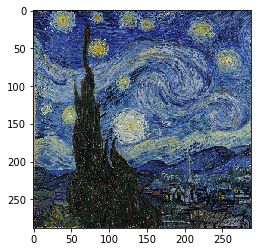

In [15]:
style = Image.open(path+'/data1.jpg')
style = style.resize(np.divide(style.size,3.5).astype('int32')); 
style = np.array(style)[:shp[0], :shp[1], :shp[2]]
plt.imshow(style);


## Transformation Network <br>
Architecture from supplementary material https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16Supplementary.pdf

In [16]:
def res_crop_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1), 'valid')
    x = conv_block(x,  nf, 3, (1,1), 'valid', False)
    ip = Lambda(lambda x: x[:, 2:-2, 2:-2])(ip)
    return keras.layers.merge([x, ip], mode='sum')

In [17]:
inp = Input(shp)
x=ReflectionPadding2D((40, 40))(inp)
x=conv_block(x,32, 9, (1,1))
x=conv_block(x, 64, 3)
x=conv_block(x, 128, 3)
for i in range(5): x=res_crop_block(x, 128)
x=up_block(x, 64, 3)
x=up_block(x, 32, 3)
x=Convolution2D(3, (9, 9), activation='tanh', padding='same')(x)
outp=Lambda(lambda x: (x+1)*127.5)(x)

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  """
/opt/anaconda/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


## Loss Network

In [74]:
vgg_inp=Input(shp)
vgg= VGG16(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))
for l in vgg.layers: l.trainable=False

In [88]:
def get_outp(m, ln): return m.get_layer(f'block{ln}_conv2').output
vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [2,3,4,5]])
#One network for input img and the other for the previous networks output.
stargs = [K.variable(o) for o in
               vgg_content.predict(np.expand_dims(style,0))]
vgg1 = vgg_content(outp)
vgg2 = vgg_content(vgg_inp)

In [89]:
[K.eval(K.shape(o)) for o in stargs]

[array([  1, 144, 144, 128], dtype=int32),
 array([  1,  72,  72, 256], dtype=int32),
 array([  1,  36,  36, 512], dtype=int32),
 array([  1,  18,  18, 512], dtype=int32)]

In [90]:
def gram_matrix_b(x):
    #permute dimensions takes in the tensor and pattern of new dimensions
    x = K.permute_dimensions(x, (0, 3, 1, 2))
    s = K.shape(x) 
    feat = K.reshape(x, (s[0], s[1], s[2]*s[3]))
    return K.batch_dot(feat, K.permute_dimensions(feat, (0, 2, 1))) / K.prod(K.cast(s[1:], K.floatx()))

In [109]:
def loss_fn(x): 
    res = 0; n=len(stargs)
    for i in range(n): 
        res += mean_sqr_b(gram_matrix_b(x[i]) - gram_matrix_b(stargs[i]))  /2.
        res += (mean_sqr_b(x[i+n]-x[i]) * w[i]) 
    return res

In [ ]:
w=[0.1, 0.2, 0.6, 0.1]

In [110]:
m_st = Model([inp, vgg_inp], Lambda(loss_fn)(vgg1+vgg2))

In [111]:
targs = np.zeros((hr.shape[0], 1))

In [112]:
m_st.compile('adam', 'mse')
m_st.fit([hr, hr], targs, 8, 2, **parms)

HBox(children=(IntProgress(value=0, description='Training', max=2), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=19439), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=19439), HTML(value='')))

In [ ]:
K.set_value(m_st.optimizer.lr, 1e-4)
m_st.fit([hr, hr], targs, 16, 1, **parms)

HBox(children=(IntProgress(value=0, description='Training', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=19439), HTML(value='')))

In [116]:
top_model = Model(inp, outp)

In [117]:
img = Image.open(path+'/index288.jpg')
img = np.expand_dims(np.array(img), 0)

(1, 288, 288, 3)

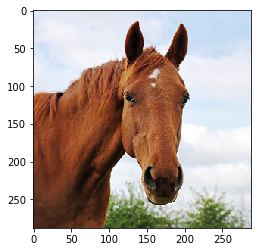

In [118]:
plt.imshow(img.reshape([288,288,3])); shp=img.shape;shp

In [119]:
p = top_model.predict(img)

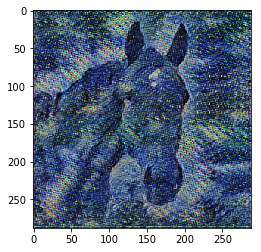

In [120]:
plt.imshow(p[0].astype('uint8'));

In [106]:
p = top_model.predict(hr[:20])